In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
scores_dir = Path("designed/scores")
max_round = 4
nanobodies = ["H11-D4", "Nb21", "Ty1", "VHH-72"]
score_types = ["log_likelihood_ratio", "Interface_pLDDT", "Interface_Residue_Count", "Interface_Atom_Count", "dG_separated", "weighted_score"]

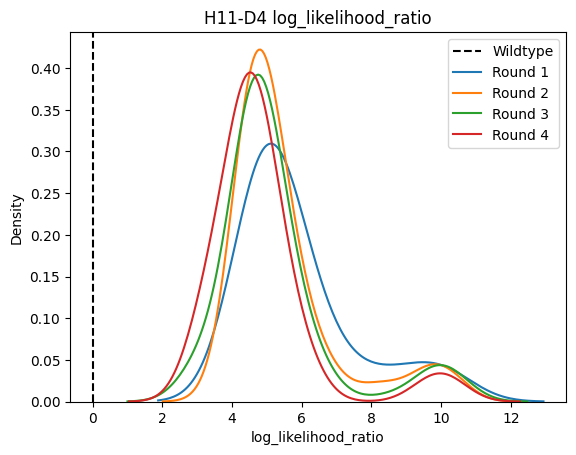

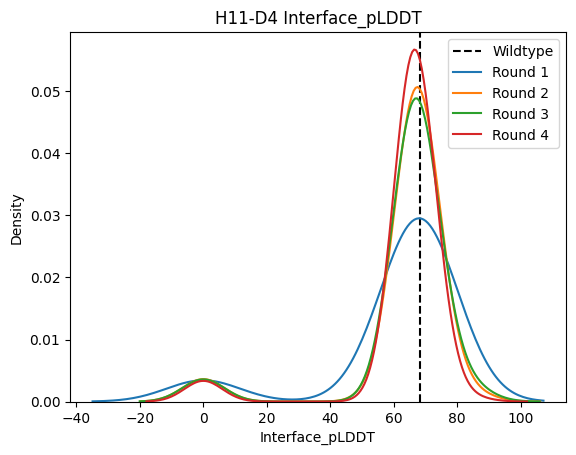

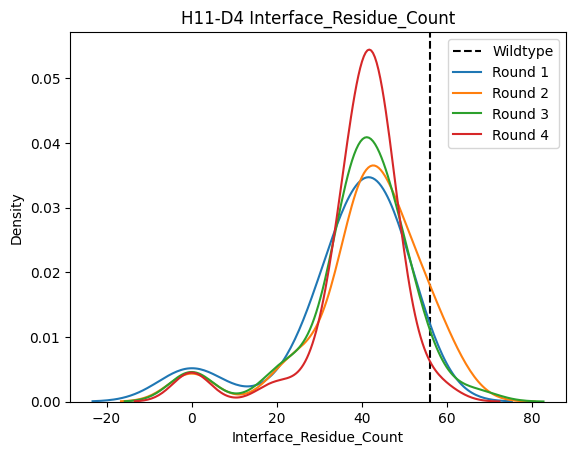

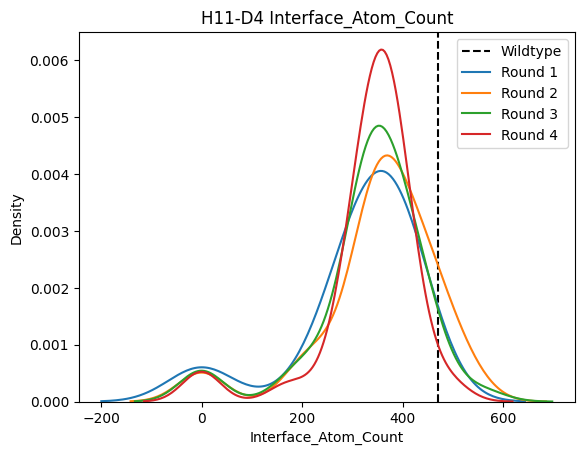

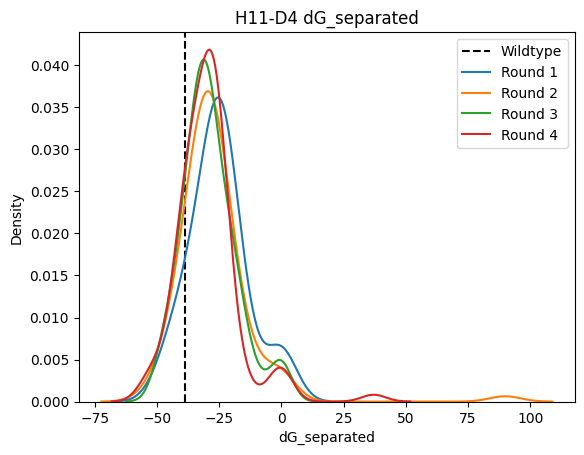

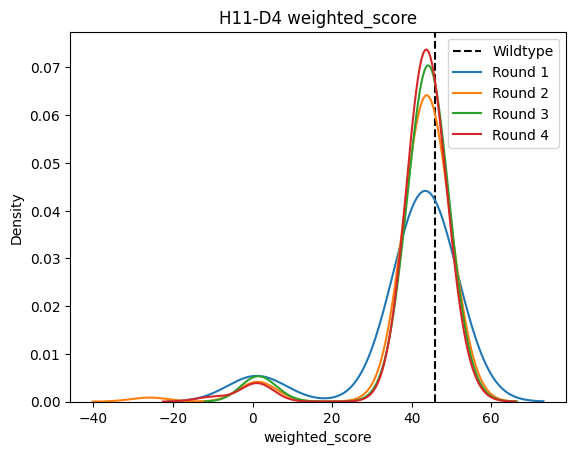

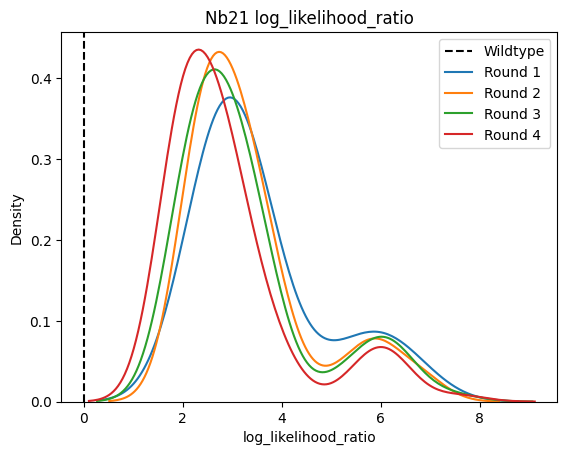

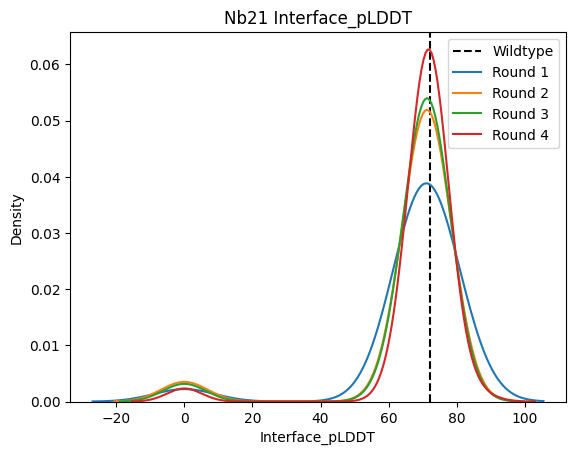

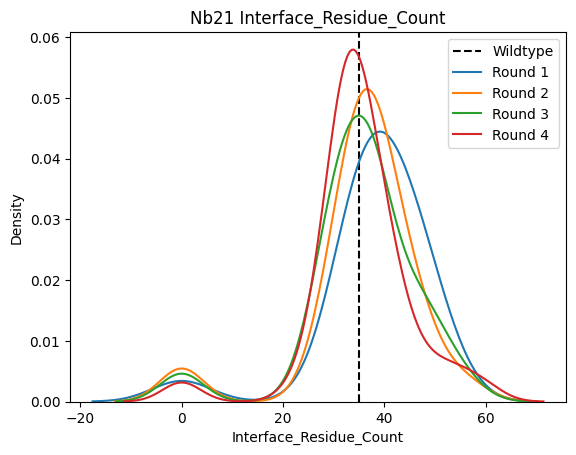

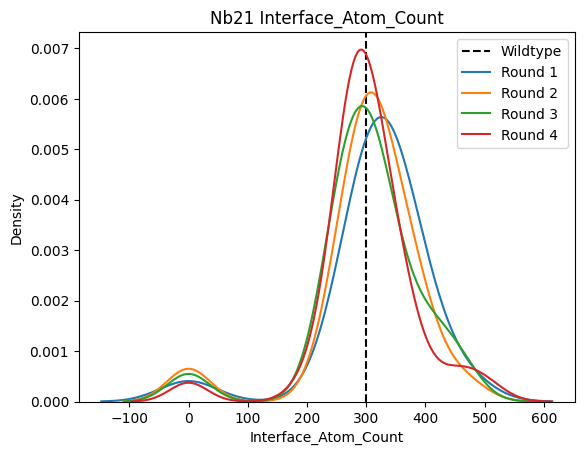

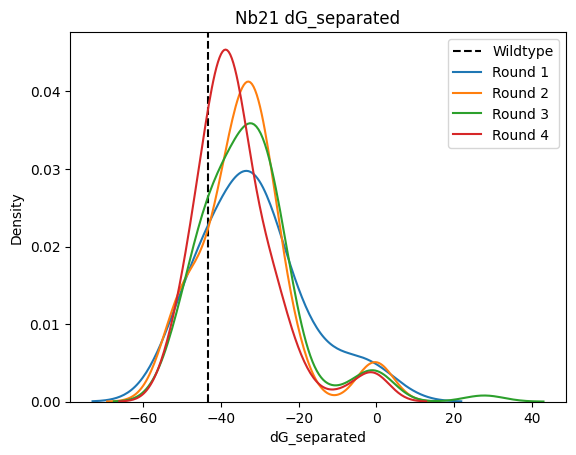

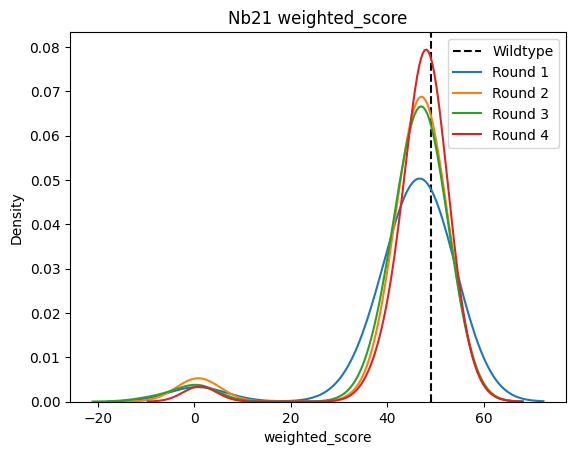

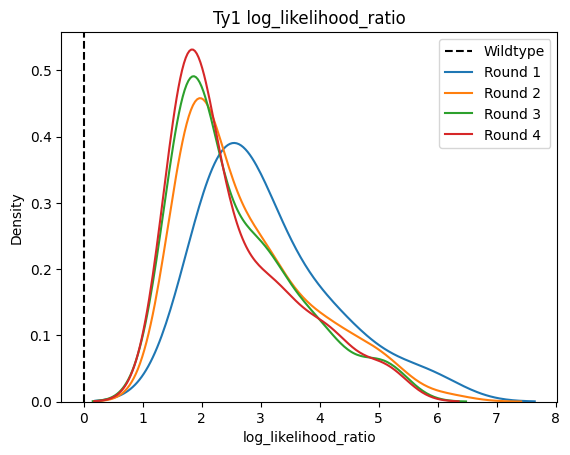

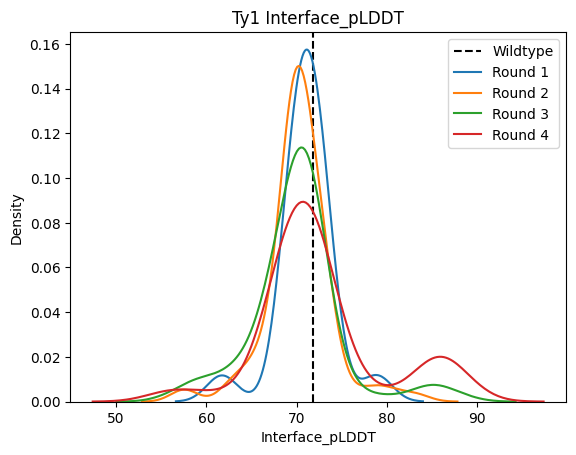

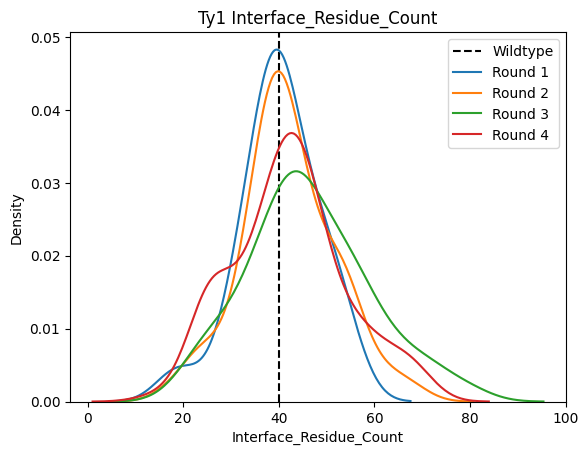

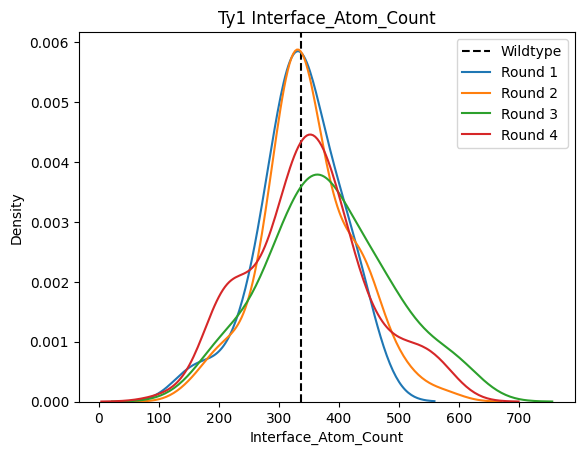

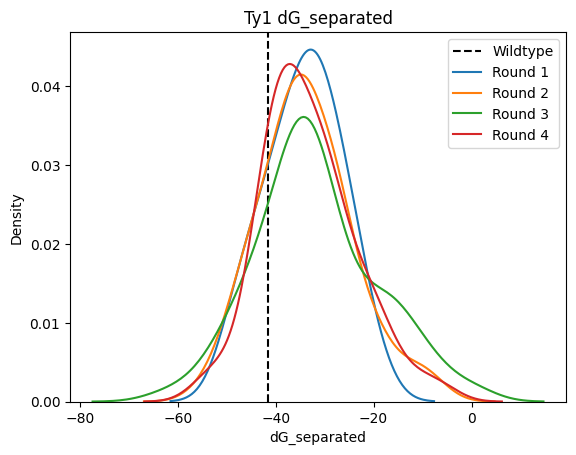

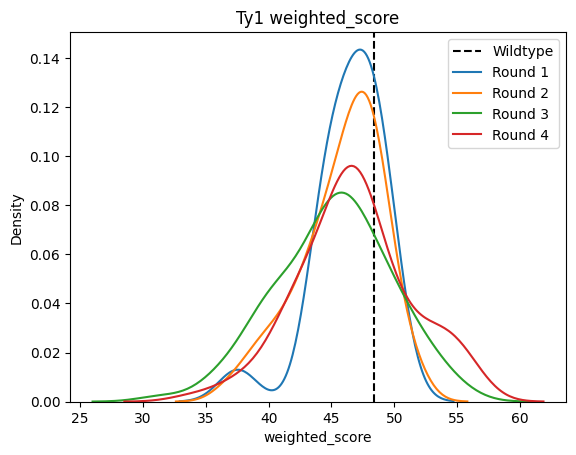

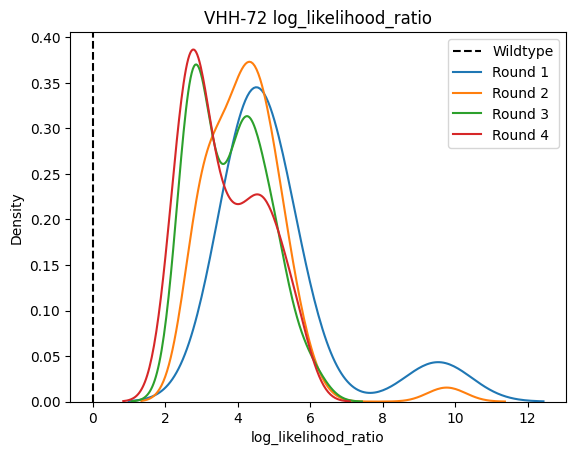

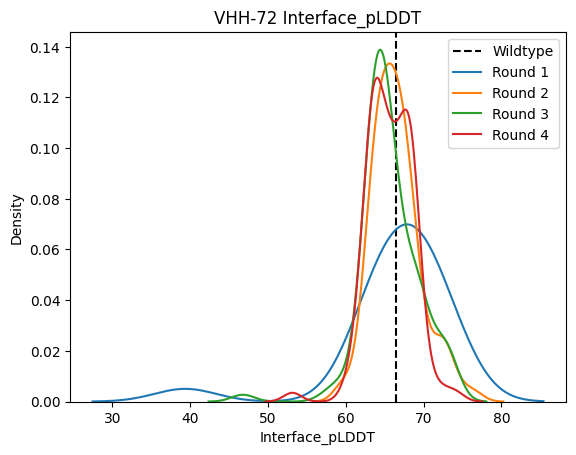

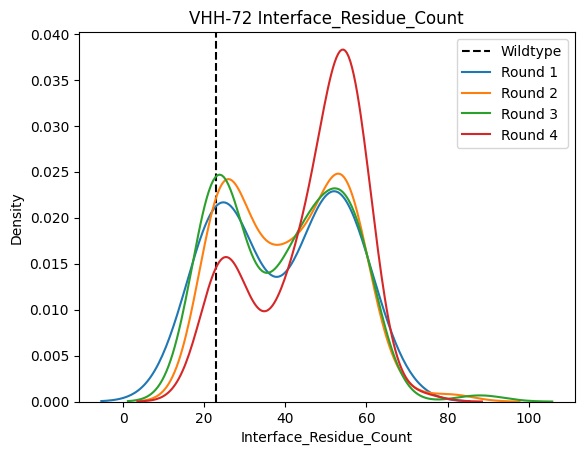

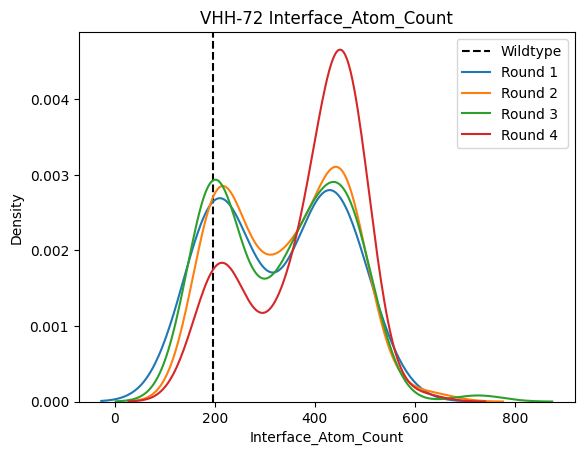

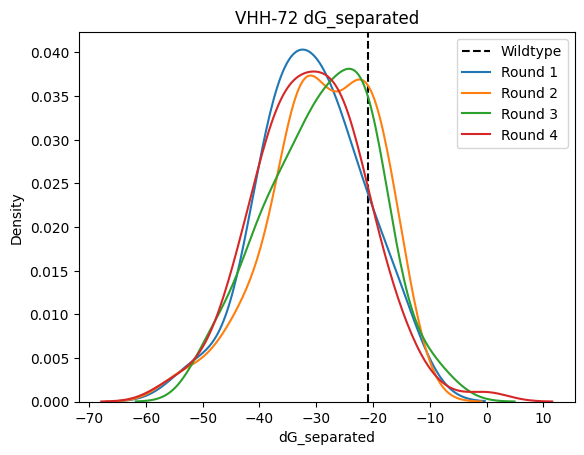

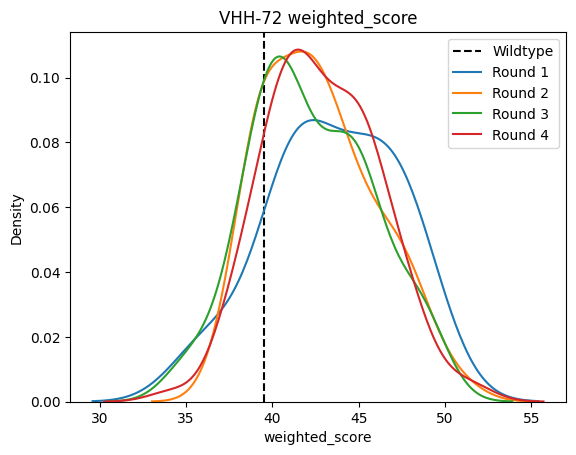

In [21]:
for nanobody in nanobodies:
    for score_type in score_types:
        plt.clf()
        for round_num in range(max_round + 1):
            scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}_all.csv"
            scores = pd.read_csv(scores_path)
            if round_num == 0:
                assert len(scores) == 1
                plt.axvline(scores.iloc[0][score_type], color="black", linestyle="--", label="Wildtype")
            else:
                sns.kdeplot(data=scores, x=score_type, label=f"Round {round_num}")
        plt.title(f"{nanobody} {score_type}")
        plt.legend()
        plt.show()